<a href="https://colab.research.google.com/github/mmistroni/TensorFlowPlayground/blob/master/RNNTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import platform
import tensorflow as tf
# Importing S&P Prices
print (pd.__version__)
print (tf.__version__)
print (platform.python_version())

standard_and_poor = [
    2924.590088,2923.429932,2925.51001,2901.610107,2885.570068,
    2884.429932,2880.340088,2785.679932,2728.370117,2767.129883,
    2750.790039,2809.919922,2809.209961,2768.780029,2767.780029,
    2755.879883,2740.689941,2656.100098,2705.570068,2658.689941,
    2641.25, 2682.629883]



0.22.0
1.12.0
3.6.6


**Retrieving S&P Historical Prices **

In [5]:
!pip install pandas_datareader

    100% |████████████████████████████████| 112kB 2.7MB/s 
    100% |████████████████████████████████| 5.8MB 4.0MB/s 


In [0]:
# Fetching Standard and Poors Results
import pandas_datareader as pdr
from datetime import date, timedelta
startdate = date.today() - timedelta(days=250)
stock_data = pdr.get_data_yahoo('^GSPC', startdate, date.today())


<class 'pandas.core.frame.DataFrame'>


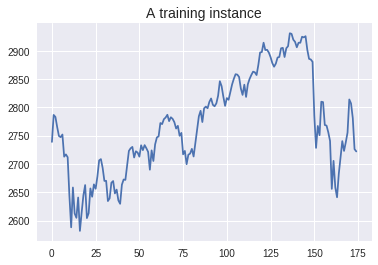

In [7]:
stock_data.shape[0]
print (type(stock_data))
adjClose = np.stack(stock_data['Close'])

# Since we always want to predict the future, we take the latest 10% of data as the test data.
# Split into train / test so that you can use the test to find accuracy.
# Train is used to train, and test to predict, to see the accuracy, Then we can use last price today to predict tomorrow, and so on

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.title("A training instance", fontsize=14)
plt.plot(adjClose)



In [54]:
# Getting next lot
'''
class RNNConfig():
    input_size=1
    num_steps=30
    lstm_size=128
    num_layers=1
    keep_prob=0.8
    batch_size = 64
    init_learning_rate = 0.001
    learning_rate_decay = 0.99
    init_epoch = 5
    max_epoch = 50

'''

# Problem here is different htan from the book. We need to use 20 inputs to predict the next 20 outputs......, not use one by one
# So we need to redo sample by having same inputs and outputs. Follow stock price example rather than Tensorflow book..


t_min, t_max = 0, 30
resolution = 0.1
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)
    
def time_series2():
    return adjClose

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    print ('Ys shape is:{0}'.format(ys.shape))
    return ys[:, 1:].reshape(-1, n_steps, n_inputs), ys[:, 1:].reshape(-1, n_steps, n_outputs) # first one is (0, len-2), second is (1,len)
  
def next_batch2(batch_size, num_steps):
    # We have different shape of data...
    seq = adjClose
    seq = [np.array(seq[i * n_inputs: (i + 1) * batch_size]) 
       for i in range(len(seq) // n_inputs)]

    # Split into groups of `num_steps`
    X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
    y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])

    return X, y
    
    

adhcs shape is:(17, 10)


In [57]:
X_batch, y_batch = next_batch(1, n_steps)
# TODO neex to inspect what's in the array
print (type(X_batch))
print(X_batch.shape)
print(y_batch.reshape(-1, 1, 1).shape)
print(n_steps, n_inputs, n_inputs)
#print(y_batch)
print (adjClose.shape)


Ys shape is:(1, 21)
<class 'numpy.ndarray'>
(1, 20, 1)
(20, 1, 1)
20 1 1
(175,)


SIMPLE RNN EXAMPLE

In [0]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()


X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name="inputs")
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs], name="targets") #)

cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


In [0]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


In [0]:
learning_rate = 0.001
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()




In [52]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):  # this is trained always with the same batch
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        #print('xbatch shape {0} ybach shape{1}'.format(X_batch.shape, y_batch.shape))
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
            
    saver = tf.train.Saver()
    preds = []
    # Attempt to predict the next price
    #pred = sess.run(training_op, feed_dict={X: X_test})
    #print(pred)

0 	MSE: 12.396139
100 	MSE: 0.3583199
200 	MSE: 0.07845444
300 	MSE: 0.045805182
400 	MSE: 0.006518061
500 	MSE: 0.005885538
600 	MSE: 0.0037363665
700 	MSE: 0.004255545
800 	MSE: 0.003642384
900 	MSE: 0.002420173
1000 	MSE: 0.002107153
1100 	MSE: 0.0019064755
1200 	MSE: 0.0010598444
1300 	MSE: 0.0013258518
1400 	MSE: 0.0014459842


In [0]:
n_iterations = 1500
batchsize = 50
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  
  
# GSPC folder id =1B1gbnhSSUNPRZMsRZVSIJDh5bNekFCBe

train_downloaded = drive.CreateFile({'id': '1B1gbnhSSUNPRZMsRZVSIJDh5bNekFCBe'})
train_downloaded.GetContentFile('train.csv')



title: GSPC-Historical.csv, id: 1B1gbnhSSUNPRZMsRZVSIJDh5bNekFCBe
title: Datasets, id: 1OQMqRiVXqsM7SVZd6lj3h3ACKQFGSgZ4
title: Colab Notebooks, id: 1Rqah8X8c71WCHDpBk68UPNHMrAG-5kJe
title: Marco Mistroni CV - 2018.docx, id: 1a5DoEznroDBRKcmGbZUojm9BSMuMc4xoLd900eoZAbA
title: XXXX5866_GainLoss_Unrealized_20180812-010701, id: 1JzTjhcEs25K_TgEVgeqLBKNgjDYzYqCVCrZGZtexc-I
title: XXXX5866_GainLoss_Unrealized_20180812-010701, id: 1p_YPvbqzuJgGGAicTh6UUf1w27__lzCoxMkuFYunUdY
title: stockReport, id: 1e4BJNQc9rBqwCrqOzipRUrBfYGsL4mY83R492fdhLc8
title: stockReport.xls, id: 0B_YgqHiyR66iMlNlNE0zT0JlM0hveVdaU1lreXlCeXNMWkxZ
title: XXXX5866_GainLoss_Unrealized_20180812-010701.xlsx, id: 0B_YgqHiyR66iX2puVlNYXzA5OFpjR2FWdWRZbndKd1RPNVQ0
title: Bathrooms quote.docx, id: 0B_YgqHiyR66iWHBiSGhHTnF2TmZUZWxmZ1hkMHhEbDMtOGJZ
title: Spark.odt, id: 1AV2nixj1sf4mlup-xLneszSlmEEBFl4U5-eFwF0PYGc
title: Eurocity - mission control.pdf, id: 0B_YgqHiyR66iNllEdjZHX2w1RlRPU1VBRVAtTktnVm84bkxR
title: candidate-test.zi

In [0]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-10,2881.389893,2886.929932,2875.939941,2877.129883,2877.129883,2731400000
1,2018-09-11,2871.570068,2892.520020,2866.780029,2887.889893,2887.889893,2899660000
2,2018-09-12,2888.290039,2894.649902,2879.199951,2888.919922,2888.919922,3264930000
3,2018-09-13,2896.850098,2906.760010,2896.389893,2904.179932,2904.179932,3254930000
4,2018-09-14,2906.379883,2908.300049,2895.770020,2904.979980,2904.979980,3149800000
5,2018-09-17,2903.830078,2904.649902,2886.159912,2888.800049,2888.800049,2947760000
6,2018-09-18,2890.739990,2911.169922,2890.429932,2904.310059,2904.310059,3074610000
7,2018-09-19,2906.600098,2912.360107,2903.820068,2907.949951,2907.949951,3280020000
8,2018-09-20,2919.729980,2934.800049,2919.729980,2930.750000,2930.750000,3337730000
9,2018-09-21,2936.760010,2940.909912,2927.110107,2929.669922,2929.669922,5607610000
